<a href="https://colab.research.google.com/github/mostafa-ja/mal_adv3/blob/main/malware_cnn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

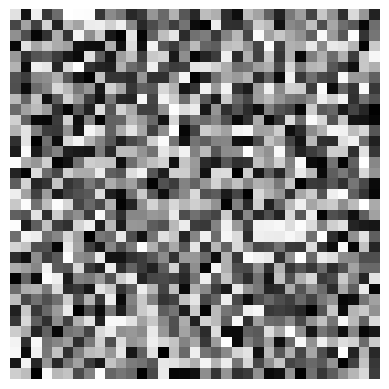

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming binary_vector is your 1D binary vector of length 10000
binary_vector = np.random.randint(2, size=9800)

# Reshape the vector into a 2D array with each element being an 8-length binary vector
image = np.reshape(binary_vector, (35, 35, 8))

# Convert binary values to gray-scale intensities
gray_image = np.packbits(image, axis=-1)

# Display the gray-scale image
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()


In [2]:
download_links = ['https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz',
                  'https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt'
]


import gdown
output_filepath = '/content/'
for link in download_links:
  gdown.download(link, output_filepath)

Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/X_redefined_sparse_matrix.npz
To: /content/X_redefined_sparse_matrix.npz
100%|██████████| 2.31M/2.31M [00:00<00:00, 14.4MB/s]
Downloading...
From: https://github.com/mostafa-ja/mal_adv3/raw/main/data/labels.pt
To: /content/labels.pt
100%|██████████| 517k/517k [00:00<00:00, 8.03MB/s]


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy import sparse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch.nn.functional as F
import random
import time


torch.manual_seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load dataset
X_redefined = sparse.load_npz("X_redefined_sparse_matrix.npz")
labels_tensor = torch.load('labels.pt')

# Split data into train, validation, and test sets with stratified sampling
X_train_val, X_test, labels_train_val, labels_test = train_test_split(X_redefined, labels_tensor, test_size=0.2, stratify=labels_tensor, random_state=42)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=0.2, stratify=labels_train_val, random_state=42)

# Combine features and labels into datasets
# we use dtype=torch.int8, for Memory-Efficient here, later we will convert to float
train_dataset = TensorDataset(torch.tensor(X_train.toarray(), dtype=torch.int8), labels_train)
val_dataset = TensorDataset(torch.tensor(X_val.toarray(), dtype=torch.int8), labels_val)
test_dataset = TensorDataset(torch.tensor(X_test.toarray(), dtype=torch.int8), labels_test)

# Clear unnecessary variables
del X_redefined, labels_tensor, X_train_val, X_test, labels_train_val, labels_test, X_train, X_val, labels_train, labels_val

In [5]:
# Define the DataLoader for training, validation, and test sets
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
def pad_binary_vector(binary_vector, new_size):
    batch_size, vector_length = binary_vector.size()

    # Calculate the number of zeros to add
    num_zeros = new_size - vector_length

    # Create a tensor filled with zeros
    zeros_tensor = torch.zeros(batch_size, num_zeros, dtype=torch.int)

    # Concatenate the binary vector with the zeros tensor along the second dimension
    padded_binary_vector = torch.cat([binary_vector, zeros_tensor], dim=1)

    return padded_binary_vector

In [7]:
def batch_binary_vectors_to_gray_images(binary_vectors, image_size=36):
    """
    Convert a batch of binary vectors to gray-scale images.

    Parameters:
        batch_binary_vectors (numpy.ndarray): Batch of binary vectors with shape (batch_size, vector_length).
        image_size (int): Size of the square image (default is 36).

    Returns:
        gray_images: Batch of gray-scale images with shape (batch_size, image_size, image_size).
    """
    batch_binary_vectors = pad_binary_vector(binary_vectors, 10368)

    # Reshape each binary vector in the batch into a 2D array with each element being an 8-length binary vector
    batch_images = np.reshape(batch_binary_vectors, (-1, image_size, image_size, 8))

    # Convert binary values to gray-scale intensities
    gray_images = np.packbits(batch_images, axis=-1)

    # Remove the last dimension (single channel) from the gray_images array
    gray_images = np.squeeze(gray_images, axis=-1)

    return gray_images


torch.Size([256, 10000])
torch.Size([256, 1])
(256, 36, 36)


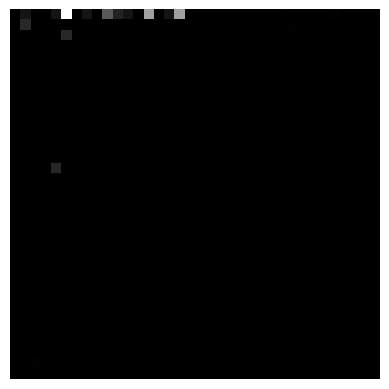

In [8]:
for X,Y in train_loader:
  print(X.shape)
  print(Y.shape)
  break

m = batch_binary_vectors_to_gray_images(X, image_size=36)
print(m.shape)

plt.imshow(m[2], cmap='gray')
plt.axis('off')
plt.show()

(256, 36, 36)


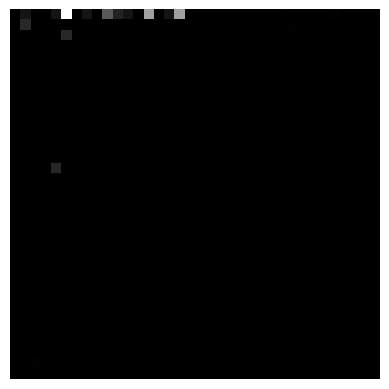

In [9]:
a = torch.zeros(256, 10368, dtype=torch.int)
a[:,:10000] =  X

m = batch_binary_vectors_to_gray_images(a, image_size=36)
print(m.shape)

plt.imshow(m[2], cmap='gray')
plt.axis('off')
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MalwareDetectorCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super(MalwareDetectorCNN, self).__init__()
        # Convolutional layers with ReLU activation
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(p=0.2)  # Adjust dropout rate as needed

        # Flatten layer
        self.flatten = nn.Flatten()

        # Fully connected layers with ReLU activation
        self.fc1 = nn.Linear(2048, 256)  # Input size based on conv layers
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Consider adding dropout after fc1 as well
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification (malware or benign)
        return x

In [11]:
a = torch.tensor(m)
a.shape

torch.Size([256, 36, 36])

In [12]:
# Example usage
model = MalwareDetectorCNN()

model(a/255.)

tensor([[0.5008],
        [0.4982],
        [0.4989],
        [0.4975],
        [0.4977],
        [0.4987],
        [0.4963],
        [0.4979],
        [0.4969],
        [0.4965],
        [0.4991],
        [0.4985],
        [0.4982],
        [0.5001],
        [0.4968],
        [0.4993],
        [0.4997],
        [0.4991],
        [0.4977],
        [0.4983],
        [0.4990],
        [0.4980],
        [0.4990],
        [0.4987],
        [0.4994],
        [0.4967],
        [0.4967],
        [0.4987],
        [0.4996],
        [0.4986],
        [0.4997],
        [0.4970],
        [0.4975],
        [0.5000],
        [0.4972],
        [0.5001],
        [0.4960],
        [0.4964],
        [0.5002],
        [0.4970],
        [0.4966],
        [0.4993],
        [0.4993],
        [0.4988],
        [0.4980],
        [0.4977],
        [0.4958],
        [0.4992],
        [0.4971],
        [0.4998],
        [0.4985],
        [0.4988],
        [0.4969],
        [0.4998],
        [0.4979],
        [0

In [13]:
aa - as

SyntaxError: invalid syntax (<ipython-input-13-b3e4d17bf9c9>, line 1)

In [19]:
from torch.optim.lr_scheduler import LambdaLR

# Define a learning rate warm-up and decay function
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch+1) / float(max(1, warmup_epochs))
    else:
        return lr_decay ** (epoch - warmup_epochs)

# Define warm-up epochs, learning rate decay factor, and other hyperparameters
warmup_epochs = 5
lr_decay = 0.97
initial_lr = 0.001

# Create an instance of the model and move it to the GPU
# model = MalwareDetectorCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Create a learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Initialize variables to track best F1 score and corresponding model state
best_f1_score = 0.0
best_model_state = None

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    print(optimizer.param_groups[0]['lr'])

    # Step the learning rate scheduler
    scheduler.step()




0.0002
0.0004
0.0006
0.0008
0.001
0.001
0.0009699999999999999
0.0009408999999999999
0.000912673
0.00088529281
0.0008587340257
0.0008329720049289998
0.0008079828447811299
0.0007837433594376959
0.0007602310586545651
0.0007374241268949281
0.0007153014030880803
0.0006938423609954377
0.0006730270901655746
0.0006528362774606074
0.0006332511891367892
0.0006142536534626855
0.0005958260438588049
0.0005779512625430407
0.0005606127246667495
0.000543794342926747
0.0005274805126389446
0.0005116560972597763
0.0004963064143419829
0.00048141722191172336
0.0004669747052543717
0.0004529654640967405
0.0004393765001738383
0.0004261952051686231
0.0004134093490135644
0.00040100706854315747
0.00038897685648686274
0.00037730755079225687
0.00036598832426848916
0.00035500867454043444
0.0003443584143042214
0.00033402766187509475
0.0003240068320188419
0.00031428662705827666
0.0003048580282465283
0.0002957122873991325
0.00028684091877715853
0.00027823569121384375
0.0002698886204774284
0.00026179196186310554
0.0002

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Define a learning rate warm-up and decay function
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch+1) / float(max(1, warmup_epochs))
    else:
        return lr_decay ** (epoch - warmup_epochs)

# Define warm-up epochs, learning rate decay factor, and other hyperparameters
warmup_epochs = 5
lr_decay = 0.97
initial_lr = 0.001

# Create an instance of the model and move it to the GPU
model = MalwareDetectorCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Create a learning rate scheduler
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Initialize variables to track best F1 score and corresponding model state
best_f1_score = 0.0
best_model_state = None

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_train, labels_train in train_loader:
        labels_train = labels_train.to(device)
        images_train = torch.tensor(batch_binary_vectors_to_gray_images(X_train, image_size=36), device=device) / 255.0
        optimizer.zero_grad()
        outputs_train = model(images_train)
        loss_train = criterion(outputs_train.squeeze(), labels_train.squeeze())
        loss_train.backward()
        optimizer.step()

        running_loss += loss_train.item()

        # Calculate training accuracy
        predicted_train = torch.round(outputs_train.squeeze())
        total_train += labels_train.size(0)
        correct_train += (predicted_train == labels_train.squeeze()).sum().item()

    train_accuracy = 100 * correct_train / total_train
    avg_loss = running_loss / len(train_loader)

    print('-----------------------------------------------------')
    print('Learning raet : ',optimizer.param_groups[0]['lr'])
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Step the learning rate scheduler
    scheduler.step()

    # Evaluate the model on the validation dataset
    model.eval()
    true_labels_val = []
    predicted_labels_val = []
    with torch.no_grad():
        for X_val, labels_val in val_loader:
            labels_val = labels_val.to(device)
            val_images = torch.tensor(batch_binary_vectors_to_gray_images(X_val, image_size=36), device=device) / 255.0
            val_outputs = model(val_images)
            predicted_val = torch.round(val_outputs.squeeze())

            # Append true and predicted labels to the lists
            true_labels_val.extend(labels_val.squeeze().tolist())
            predicted_labels_val.extend(predicted_val.tolist())

    # Convert the lists to numpy arrays
    true_labels_val = np.array(true_labels_val)
    predicted_labels_val = np.array(predicted_labels_val)

    # Compute precision, recall, and F1 score for validation set
    precision_val = precision_score(true_labels_val, predicted_labels_val)
    recall_val = recall_score(true_labels_val, predicted_labels_val)
    f1_val = f1_score(true_labels_val, predicted_labels_val)

    print(f"Validation Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")

    # Evaluate the model on the test dataset
    true_labels_test = []
    predicted_labels_test = []
    with torch.no_grad():
        for X_test, labels_test in test_loader:
            labels_test = labels_test.to(device)
            test_images = torch.tensor(batch_binary_vectors_to_gray_images(X_test, image_size=36), device=device) / 255.0
            test_outputs = model(test_images)
            predicted_test = torch.round(test_outputs.squeeze())

            # Append true and predicted labels to the lists
            true_labels_test.extend(labels_test.squeeze().tolist())
            predicted_labels_test.extend(predicted_test.tolist())

    # Convert the lists to numpy arrays
    true_labels_test = np.array(true_labels_test)
    predicted_labels_test = np.array(predicted_labels_test)

    # Compute precision, recall, and F1 score for test set
    precision_test = precision_score(true_labels_test, predicted_labels_test)
    recall_test = recall_score(true_labels_test, predicted_labels_test)
    f1_test = f1_score(true_labels_test, predicted_labels_test)

    print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")

    # Check if the current model has the best F1 score
    if f1_val > best_f1_score:
        best_f1_score = f1_val
        best_model_state = model.state_dict()

# Save the best model based on F1


-----------------------------------------------------
Learning raet :  0.0002
Epoch [1/100], Train Loss: 0.1886, Train Accuracy: 95.43%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
-----------------------------------------------------
Learning raet :  0.0004
Epoch [2/100], Train Loss: 0.1059, Train Accuracy: 96.42%
Validation Precision: 0.8373, Recall: 0.4393, F1 Score: 0.5763
Test Precision: 0.8393, Recall: 0.4460, F1 Score: 0.5825
-----------------------------------------------------
Learning raet :  0.0006
Epoch [3/100], Train Loss: 0.0847, Train Accuracy: 97.29%
Validation Precision: 0.8033, Recall: 0.6101, F1 Score: 0.6935
Test Precision: 0.8125, Recall: 0.6196, F1 Score: 0.7031
-----------------------------------------------------
Learning raet :  0.0008
Epoch [4/100], Train Loss: 0.0768, Train Accuracy: 97.47%
Validation Precision: 0.8031, Recall: 0.6966, F1 Score: 0.7461
Test Precision: 0.8122, Recall: 0.7041, F1 Score: 0.7543
-----------------------------------------------------
Learning raet :  0.001
Epoch [5/100], Train Loss: 0.0693, Train Accuracy: 97.77%
Validation Precision: 0.8241, Recall: 0.

In [ ]:
# Load the best model
best_model_state = torch.load('best_model.pth')
model = MalwareDetectorCNN()
model.load_state_dict(best_model_state)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize test metrics
true_labels_test = []
predicted_labels_test = []

# Perform testing
with torch.no_grad():
    for X_test, labels_test in test_loader:
        labels_test = labels_test.to(device)
        test_images = torch.tensor(batch_binary_vectors_to_gray_images(X_test, image_size=36),device=device) / 255.0
        test_outputs = model(test_images)
        predicted_test = torch.round(test_outputs.squeeze())

        # Append true and predicted labels to the lists
        true_labels_test.extend(labels_test.squeeze().tolist())
        predicted_labels_test.extend(predicted_test.tolist())

# Convert the lists to numpy arrays
true_labels_test = np.array(true_labels_test)
predicted_labels_test = np.array(predicted_labels_test)

# Compute precision, recall, and F1 score for test set
precision_test = precision_score(true_labels_test, predicted_labels_test)
recall_test = recall_score(true_labels_test, predicted_labels_test)
f1_test = f1_score(true_labels_test, predicted_labels_test)

print(f"Test Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}")
